# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Mohammadreza Ebrahimi  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import numpy as np
import pdb
import cv2
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

ModuleNotFoundError: No module named 'cv2'

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

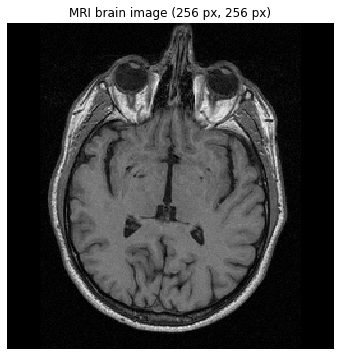

In [2]:
import skimage.io
import matplotlib.pyplot as plt

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### Pre-Processing
Altough this step is not mentioned as a necessary one, it's a good practice to check the effect of pre-processing on the final results. We will apply histogram equilization to check whether more details of the brain can be captured and a gaussian filter for noise removal purposes.

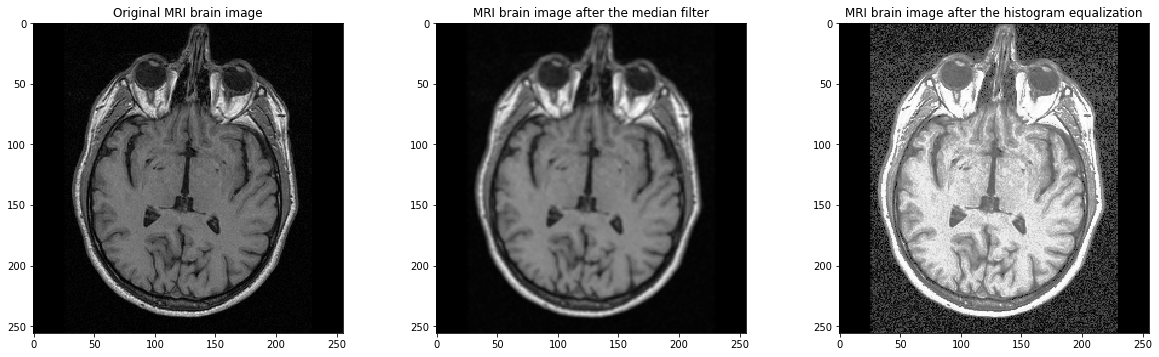

In [32]:
# Performs the median filter based on 3 points
brain_im_gauss = cv2.GaussianBlur(brain_im,(3,3),cv2.BORDER_DEFAULT)

# Performs histogram equalization
brain_im_eqhist= cv2.equalizeHist(brain_im)

titles = ['Original MRI brain image', 'MRI brain image after the median filter', 'MRI brain image after the histogram equalization']
outputs = [brain_im, brain_im_gauss, brain_im_eqhist]

fig = plt.figure(figsize=(20, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(1,4):
    ax = fig.add_subplot(1, 3, i)
    ax.imshow(outputs[i-1], cmap='gray')
    plt.title(titles[i-1])
plt.show()

### 1.2 Region growing
As introduced in the lectures, region growing is a recursive and relatively convinient approach of finding target segments in an image. For that, we have developed a simple implementation of this idea to find the pixels, corresponding to the brain tissue.
There are some important parameters that should be defined for this algorithm. First, a threshold value based on which neighbor pixles will be assumed to be part of one segmentation or not. Then we need a seed, which is the initial point and should belong to the target segment. Then, recursively, we get to the desired part.

In [7]:
def region_growing(img, ref, thresh):
    # Parameters for region growing
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    neighbor_points_list = []
    final_list = []
    neighbor_points_list.append(ref)

    # Input image parameters
    height, width = img.shape

    # Initialize segmented output image
    segmented_img = np.ones((height, width), np.uint8)
    segmented_img[ref] = 255
    j = 0
    # Region growing until intensity difference becomes greater than certain threshold
    while len(neighbor_points_list) > 0 and j < height*width:
        j += 1
        # Loop through neighbor pixels
        ref = neighbor_points_list[0]
        for i in range(4):
            # Compute the neighbor pixel position
            x_new = ref[0] + neighbors[i][0]
            y_new = ref[1] + neighbors[i][1]

            # Boundary Condition - check if the coordinates are inside the image
            check_inside = (x_new >= 0) & (y_new >= 0) & (x_new < height) & (y_new < width)

            # Add neighbor if inside and not already in segmented_img
            if check_inside:
                if abs(int(img[x_new, y_new]) - int(img[ref[0], ref[1]])) < thresh and [x_new, y_new] not in final_list and [x_new, y_new] not in neighbor_points_list:
                    neighbor_points_list.append([x_new, y_new])
                    segmented_img[x_new, y_new] = 255

        final_list.append(ref)

        # remove already checked point
        neighbor_points_list.pop(0)

    return segmented_img, len(final_list)

In [8]:
seed = (137, 148)
diff = 8
seg_img, total_pixels = region_growing(brain_im, seed, diff)

In [6]:
seed = (100, 100)
diff = 8
seg_img_gauss, tp = region_growing(brain_im_gauss, seed)

The total number of pixels is = 16298


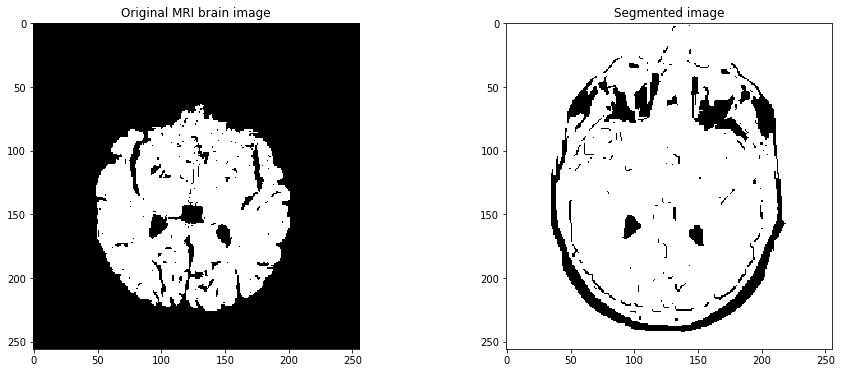

In [9]:
print('The total number of pixels is = ' + str(total_pixels))

titles = ['Region Growing without pre-processing', 'Region Growing with pre-processing']
outputs = [seg_img, seg_img_gauss]

fig = plt.figure(figsize=(15, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(1,3):
    ax = fig.add_subplot(1, 2, i)
    ax.imshow(outputs[i-1], cmap='gray')
    plt.title(titles[i-1])
plt.show()

Based on this result, we observe that in the case we perform pre-processing, we need to use another threshold otherwise, we end up with a totally wrong result. Hence, in the next section, we used another threshold. (specified as diff)

In [19]:
seed = (100, 100)
diff = 4 #changing tje threshold becasue some smoothing has been applied
seg_img_gauss, tp = region_growing(brain_im_gauss, seed, diff)

The total number of pixels is = 16298


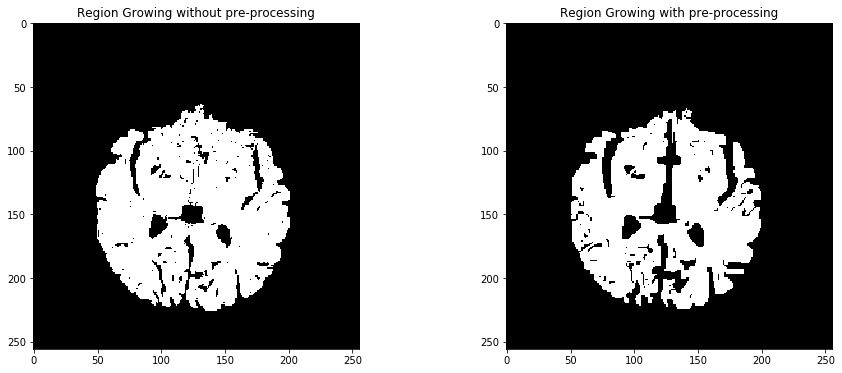

In [24]:
print('The total number of pixels is = ' + str(total_pixels))

titles = ['Region Growing without pre-processing', 'Region Growing with pre-processing']
outputs = [seg_img, seg_img_gauss]

fig = plt.figure(figsize=(15, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(1,3):
    ax = fig.add_subplot(1, 2, i)
    ax.imshow(outputs[i-1], cmap='gray')
    plt.title(titles[i-1])
plt.show()

We can see some improvements by using a gaussian blurring since some areas formerly were taken to belong to the brain, whereas it wasn't the case. So, pre-processing can be useful or destructive, depending on the way we use it.

### 1.3 Contour detection
This part is less straightforward, and it's rather composed of multiple steps. The reason is that these algorithms generally depend on edge detection, and the skull part in the image contains quite a few edges that interfere with the process of separating the brain tissue.

In [5]:
#Sobel , LoG
from scipy import ndimage
from skimage.filters import sobel

brain_im_gauss = cv2.GaussianBlur(brain_im,(5,5),0)

im_log = ndimage.gaussian_laplace(brain_im, sigma=2)
im_sob = sobel(brain_im)

im_gsob = sobel(brain_im_gauss)
im_glog = ndimage.gaussian_laplace(brain_im_gauss, sigma=2)

Mean of Sobel is 0.022521248175536676.


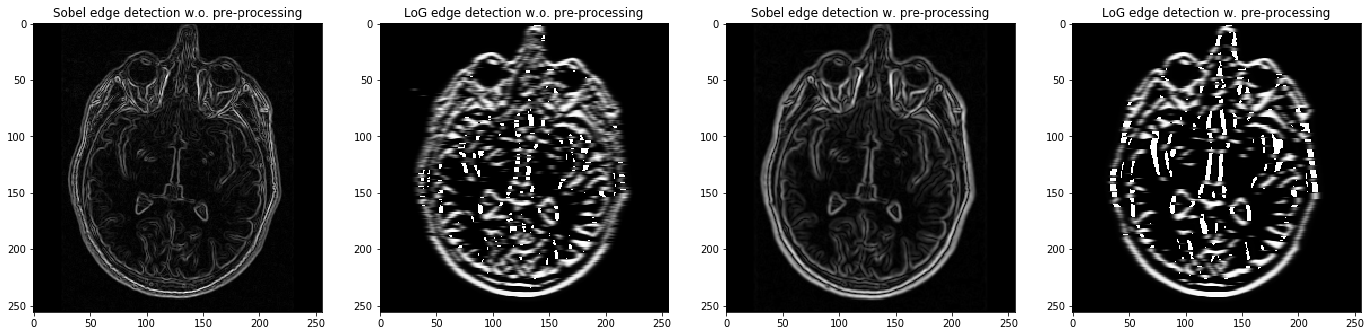

In [6]:
outputs = [im_sob, im_log, im_gsob, im_glog]
fig = plt.figure(figsize=(30, 6))
plt.gray()
titles = ['Sobel edge detection w.o. pre-processing', 'LoG edge detection w.o. pre-processing', 'Sobel edge detection w. pre-processing', 'LoG edge detection w. pre-processing']
print("Mean of Sobel is {}.".format(im_gsob.mean()))

for i in range(1,5):
    ax = fig.add_subplot(1, 5, i)
    ax.imshow(outputs[i-1])
    plt.title(titles[i-1])
plt.show()

We tried both Sobel edge detection and Laplacian of a Gaussian. Based on the results, it seems more reasonable to work with the Sobel filter. Also, it's better to work with the pre-processed version of the image since the edges are smoother and better defined in this case.

After detecting the edges, we should get rid of the ones belonging to the skull. For that, we apply simple thresholding based on the mean of the Sobel image. Then, we fill all the wholes inside the skull to have a uniform white area inside the skull. The reason is that in the case we subtract the initial thresholded image from this new one (called foreground), we can more or less get rid of the extra skull edges. One can find the result of this subtraction.

In [7]:
from skimage.filters import sobel
from scipy.ndimage.morphology import binary_fill_holes

_,binary = cv2.threshold(im_gsob,0.022,255,0)
foreground = binary_fill_holes(binary).astype(np.uint8)

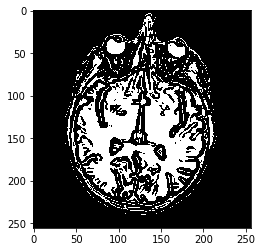

In [8]:
plt.imshow(np.abs(255*foreground - binary))

By getting to this point, we can extract the brain tissue by removing the small objects in the image. Then, as it is observable, the extracted segment is quite pouros and small. Therefore, we applied two iterations of dilation with a 2 by 2 kernel to get closer to the original brain tissue. The final result seems to be fine being aware of the necessary steps associated with contour detection of this particular case.

In [9]:
from skimage import morphology
brain_tissue = morphology.remove_small_objects((foreground*255-binary).astype(bool), min_size=500)

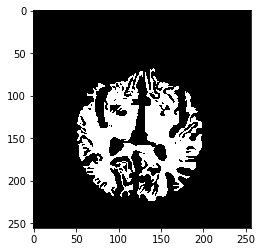

In [10]:
plt.imshow(brain_tissue)

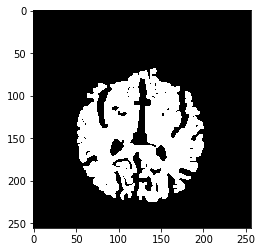

In [11]:
kernel = np.ones((2,2),np.uint8)
brain_final = cv2.dilate(brain_tissue.astype(np.uint8),kernel,iterations=2)
plt.imshow(brain_final)

Mean of Sobel is 0.022521248175536676.


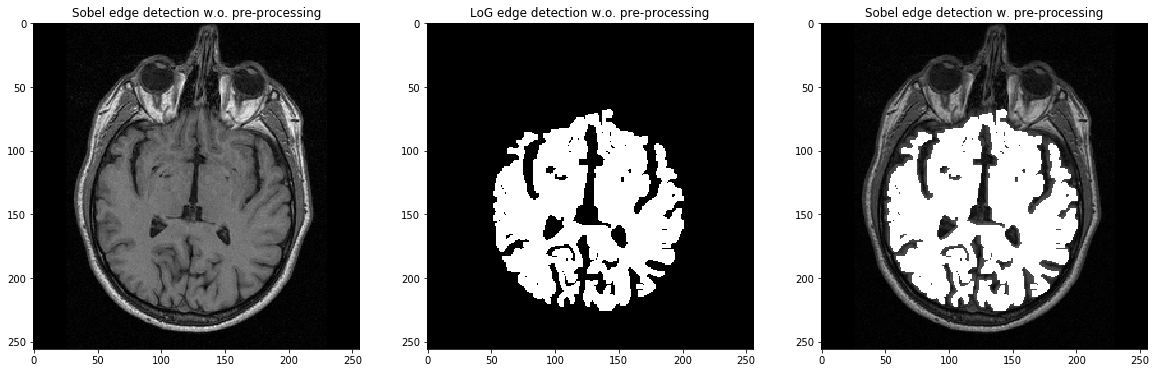

In [20]:
Highlighted_brain = (brain_final*255) | brain_im 
images = [brain_im, brain_final, Highlighted_brain]
fig = plt.figure(figsize=(20, 6))
plt.gray()
titles = ['Sobel edge detection w.o. pre-processing', 'LoG edge detection w.o. pre-processing', 'Sobel edge detection w. pre-processing', 'LoG edge detection w. pre-processing']
print("Mean of Sobel is {}.".format(im_gsob.mean()))

for i in range(1,4):
    ax = fig.add_subplot(1, 3, i)
    ax.imshow(images[i-1])
    plt.title(titles[i-1])
plt.show()

### 1.4 Additional method(s)
Add your implementation and discussion

### Thresholding + Morphology
For this part, we work with thresholding in order to seperate the brain tissue. As the contour detection section, this method is not that straightforward as well. The reason is that the pixel values of some part of the skull is quite close to that of the brain tissue. Fortunately, most parts of the skull are brighter than the brain. For this reason, we can apply the thresholding twice with different values and then by subtraction, we should be able to take out the brain part with some more post-processing.

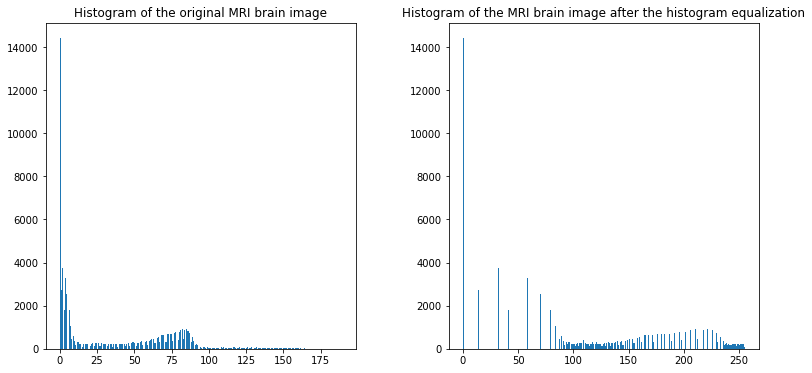

In [127]:
titles = ['Histogram of the original MRI brain image', 'Histogram of the MRI brain image after the histogram equalization']
outputs = [brain_im, brain_im_eqhist]

fig = plt.figure(figsize=(20, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(1,3):
    ax = fig.add_subplot(1, 3, i)
    ax.hist(outputs[i-1].ravel(), bins=256)
    plt.title(titles[i-1])
plt.show()

In [143]:
from skimage.morphology import square

# Finding all the white areas using a binary thresholding on equalized histogram image
_,binary= cv2.threshold(brain_im_eqhist,155,255,cv2.THRESH_BINARY)

# Finding the white areas which are not a part of brain
# Using a binary thresholding on equalized histogram image
_,skull= cv2.threshold(brain_im_eqhist,240,255,cv2.THRESH_BINARY)

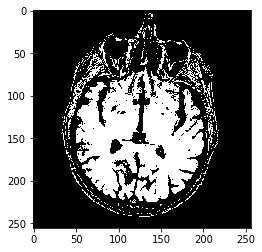

In [144]:
#adaptive
plt.imshow(skull - binary)

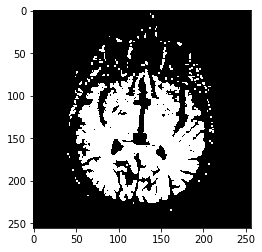

In [149]:
kernel = np.ones((2,2),np.uint8)
res = skull - binary
opening = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel)
plt.imshow(opening)

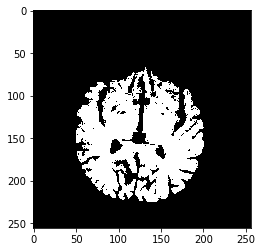

In [152]:
brain_tissue = skimage.morphology.remove_small_objects(res.astype(bool), min_size=200)
plt.imshow(brain_tissue)

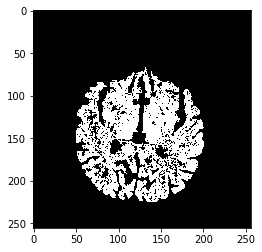

In [172]:
_,binary= cv2.threshold(brain_im_eqhist,155,255,cv2.THRESH_BINARY)

# Finding the white areas which are not a part of brain
# Using a binary thresholding on equalized histogram image
_,skull= cv2.threshold(brain_im_eqhist,230,255,cv2.THRESH_BINARY)
plt.imshow(skull - binary)
kernel = np.ones((2,2),np.uint8)
res = skull - binary
no_skull = skimage.morphology.remove_small_objects(res.astype(bool), min_size=100)
plt.imshow(no_skull)

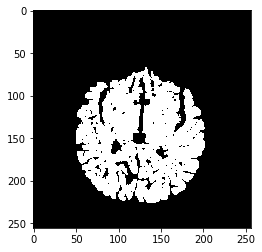

In [174]:
closing = cv2.dilate(no_skull.astype(np.uint8), kernel, iterations=1)
plt.imshow(closing)

#### Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### Ideas
a) gray scale and colored

b) check the content of three channels


c) normalization

### 2.1 Visualization

In [4]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


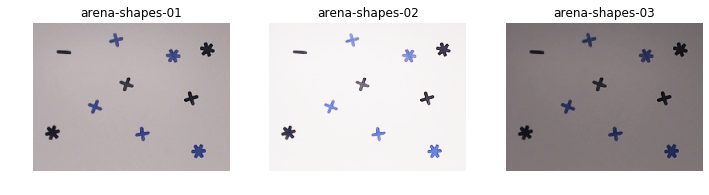

In [10]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion